In [ ]:
import pandas as pd
import numpy as np
import joblib  # <--- NEW: For saving the scaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# --- Load and Prepare Data ---
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

# Date formatting
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'], format='%m/%d/%Y')

# Sort for lag generation
train = train.sort_values(by=['store', 'item', 'date'])

# Temporal features
for df in [train, test]:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Lag and rolling features
train['lag_1'] = train.groupby(['store', 'item'])['sales'].shift(1)
train['rolling_mean_7'] = train.groupby(['store', 'item'])['sales'].shift(1).rolling(7).mean()

# Drop rows with NaNs from lag features
train = train.dropna()

# Log-transform target
train['sales_log'] = np.log1p(train['sales'])

# Feature selection
features = ['store', 'item', 'year', 'month', 'day', 'dayofweek', 'is_weekend', 'lag_1', 'rolling_mean_7']
X = train[features]
y = train['sales_log']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- SAVE SCALER ---
joblib.dump(scaler, 'scaler.pkl')
print("✅ Scaler saved to 'scaler.pkl'")

# Reshape for LSTM: [samples, timesteps, features]
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# --- LSTM Model ---
model = Sequential([
    LSTM(64, activation='relu', input_shape=(X_scaled.shape[1], X_scaled.shape[2])),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1)
])

model.compile(optimizer=Adam(0.001), loss='mse', metrics=['mae'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    batch_size=64,
    callbacks=[early_stopping, reduce_lr]
)

# Evaluate
loss, mae = model.evaluate(X_val, y_val)
print(f'Validation MSE: {loss:.4f}, MAE (log): {mae:.4f}')

# --- Prepare Test Set ---
last_known = train.groupby(['store', 'item']).last().reset_index()[['store', 'item', 'sales']]
test = test.merge(last_known, on=['store', 'item'], how='left', suffixes=('', '_lag1'))
test.rename(columns={'sales': 'lag_1'}, inplace=True)
test['rolling_mean_7'] = test['lag_1']  # Approximation due to lack of full history

# Fill missing values
test.fillna(0, inplace=True)

# Prepare test features
X_test = test[features]

# Use the same scaler used during training
X_test_scaled = scaler.transform(X_test)
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Predict and inverse log transform
y_pred_log = model.predict(X_test_scaled).flatten()
y_pred = np.expm1(y_pred_log)

# --- Submission ---
submission = test[['id', 'date', 'store', 'item']].copy()
submission['sales'] = y_pred
submission.to_csv('submission_plus.csv', index=False)
print("✅ Predictions saved to 'submission.csv'")

# --- Save Model ---
model.save('lstm_sales_model_plus.h5')
print("✅ Model saved to 'lstm_sales_model_plus.h5'")


J'ai entraîné mon modèle en utilisant Google Colab. Comme je travaillais directement dans le notebook, j'ai pris des captures d'écran des époques d'entraînement pour documenter le processus.

# Le lien de notebook : 
https://colab.research.google.com/drive/1K3BCG0Y-gRoAJGZJj9aLS1nB8O2FcFuB?usp=sharing

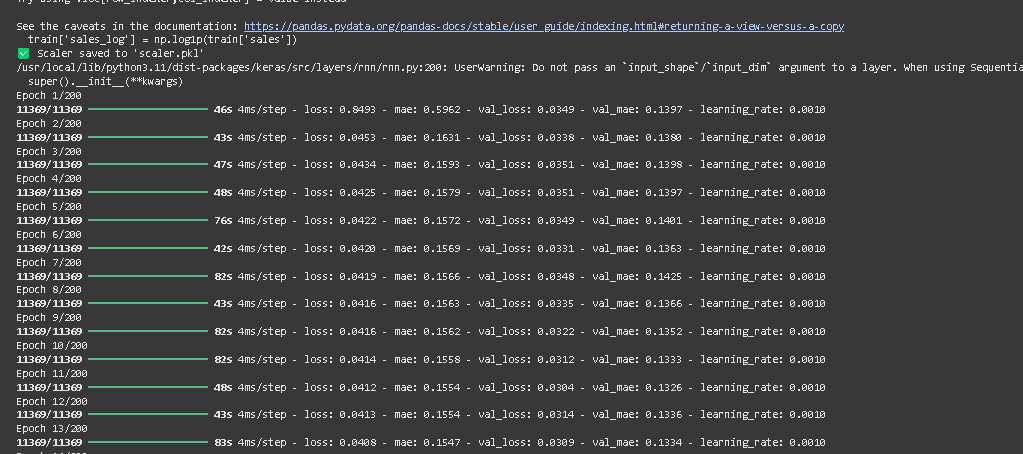
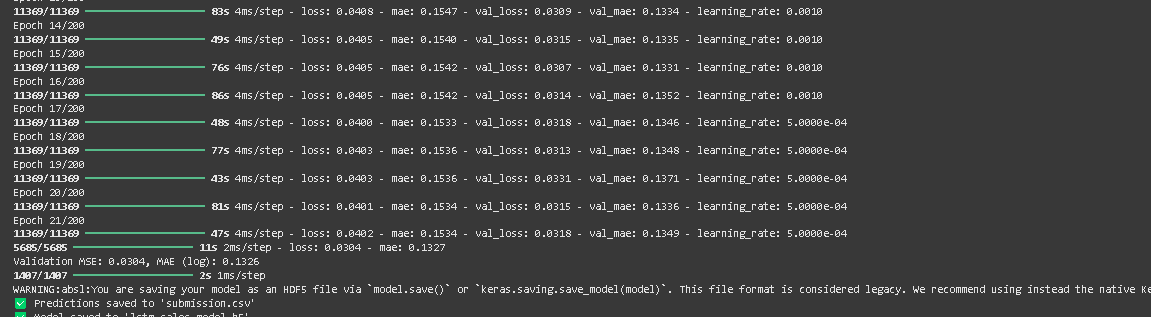